<a href="https://colab.research.google.com/github/romanzes637/nuclear-reactor/blob/master/reactor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Events



In [0]:
def tip(reactor):
  reactor.acc += 1.0

def iodine(reactor):
  reactor.acc -= 1.0

def pump_down(reactor):
  reactor.queue.append({'name': 'steam', 'work': 1.0})
  
def pump_up(reactor):
  reactor.queue.append({'name': 'water', 'work': 1.0})
  
def rod_down(reactor):
  reactor.acc -= 1.0
  
def rod_up(reactor):
  reactor.acc += 1.0  
  
def water(reactor):
  reactor.acc -= 1.0  
  
def steam(reactor):
  reactor.acc += 1.0
  
def scram(reactor):
  reactor.state = 0.0
  reactor.rate = 0.0
  reactor.acc = 0.0
  reactor.queue.append({'name': 'iodine', 'work': 1.0})

factory = {
    'rod_up': rod_up,
    'rod_down': rod_down,
    'pump_up': pump_up,
    'pump_down': pump_down,
    'steam': steam,
    'water': water,
    'iodine': iodine,
    'tip': tip,
    'scram': scram
}

# Reactor

In [0]:
from datetime import datetime, timedelta
import time
import random
import matplotlib.pyplot as plt
from google.colab import widgets

class Reactor:
  state = 0  # reactor state from 0 to 100+ (amount of enegry produced per step, max 100)
  rate = 0  # per step
  acc = 0  # per step
  produced = 0  # total energy produced
  work = 200  # working time in seconds
  step = 1  # step in seconds
  start = 0  # start time
  cur = 0  # current (step) time
  queue = [
      {'name': 'scram', 'work': 1.0},
      {'name': 'rod_up', 'work': 100.2}, 
      {'name': 'rod_up', 'work': 100.2},
      {'name': 'rod_down', 'work': 1.2}, 
      {'name': 'steam', 'work': 3.0},
      {'name': 'tip', 'work': 1.0},
      {'name': 'iodine', 'work': 40.0},
      {'name': 'pump_up', 'work': 5.0},
      {'name': 'pump_down', 'work': 5.0},
  ]  # events queue TODO clean after update_events() has been implemented
  chance = 0.0  # disaster chance for states > 100 (checked every step)
  chance_rate = 0.005 # disaster chance rate per step for states > 100

  def update_events(self):
  # TODO read from file that updated by server?
#     new_events = [
#         {'name': 'scram', 'work': 0.0},
#         {'name': 'rod_up', 'work': 4.2}, 
#         {'name': 'rod_up', 'work': 10.2}, 
#         {'name': 'rod_down', 'work': 4.2}, 
#         {'name': 'steam', 'work': 5.0},
#         {'name': 'tip', 'work': 10.0},
#         {'name': 'iodine', 'work': 4.0},
#         {'name': 'pump_up', 'work': 10.0},
#         {'name': 'pump_down', 'work': 4.0},
#     ]
    if 0 < self.state < 50:
        self.queue.append({'name': 'iodine', 'work': 1.0})  # iodine pit
    new_events = []
    self.queue.extend(new_events)
  
  def events(self):
    for e in self.queue:
      e.setdefault('start', self.cur)
      e.setdefault('end', self.cur + timedelta(seconds=e['work']))
      if self.cur <= e['end']:
#         print(e['name'])
        factory[e['name']](self)

  def run(self):
    self.start = datetime.utcnow()
    self.create_plot()
    while (datetime.utcnow() - self.start).seconds < self.work:
      time.sleep(self.step)  # wait to next step
      self.cur = datetime.utcnow()
      self.update_events()
      self.events()
      self.rate += 0.5 * self.acc
      self.state += self.rate
      self.rate += 0.5 * self.acc
      if self.state < 0:
        self.state = 0
        self.rate = 0
#         self.acc = 0  # FIXME comment?
        if self.chance > 0:
          self.chance -= self.chance_rate
      elif self.state > 100:
        self.chance += self.chance_rate
        self.produced += 100
      else:
        self.chance += self.chance_rate
        self.produced += self.state
        if self.chance > 0:
          self.chance -= self.chance_rate        
      self.plot()
      if random.uniform(0, 1) < self.chance:
          print('BOOM!!!')
          break

  
  def create_plot(self):
    self.times = []
    self.ss = []
    self.ps = []
    self.rs = []
    self.acs = []
    self.cs = []
    self.grid = widgets.Grid(3, 2, header_row=True, header_column=True)

  def plot(self):    
    self.times.append(self.cur)
    with self.grid.output_to(0, 0):
      self.grid.clear_cell()
      self.ss.append(self.state)
      plt.xlabel('time')
      plt.ylabel('%')
      plt.title('State')
      plt.plot(self.times, self.ss, 'o-r')
    with self.grid.output_to(0, 1):
      self.grid.clear_cell()
      self.ps.append(self.produced)
      plt.xlabel('time')
      plt.ylabel('energy')
      plt.title('Produced')
      plt.plot(self.times, self.ps, 'o-g')
    with self.grid.output_to(1, 0):
      self.grid.clear_cell()
      self.rs.append(self.rate)
      plt.xlabel('time')
      plt.ylabel('state per step')
      plt.title('Rate')
      plt.plot(self.times, self.rs, 'o-b')
    with self.grid.output_to(1, 1):
      self.grid.clear_cell()
      self.acs.append(self.acc)
      plt.xlabel('time')
      plt.ylabel('rate per step')
      plt.title('Acceleration')
      plt.plot(self.times, self.acs, 'o-y')
    with self.grid.output_to(2, 0):
      self.grid.clear_cell()
      print(self.cur.strftime('%H:%M:%S'))
      for e in self.queue:
        print('name: {}, start: {}, end: {}'.format(
            e['name'], e['start'].strftime('%H:%M:%S'),
            e['end'].strftime('%H:%M:%S')))
    with self.grid.output_to(2, 1):
      self.grid.clear_cell()
      self.cs.append(self.chance)
      plt.xlabel('time')
      plt.ylabel('%')
      plt.title('Disaster chance')
      plt.plot(self.times, self.cs, 'o-m')

# Run
Use CTRL + F9

,
,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

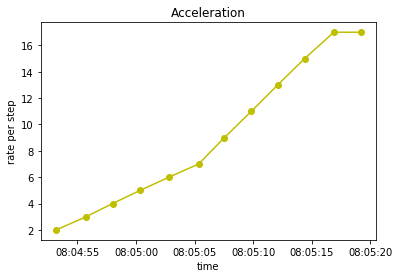

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

08:05:19
name: scram, start: 08:03:37, end: 08:03:38
name: rod_up, start: 08:03:37, end: 08:05:18
name: rod_up, start: 08:03:37, end: 08:05:18
name: rod_down, start: 08:03:37, end: 08:03:39
name: steam, start: 08:03:37, end: 08:03:40
name: tip, start: 08:03:37, end: 08:03:38
name: iodine, start: 08:03:37, end: 08:04:17
name: pump_up, start: 08:03:37, end: 08:03:42
name: pump_down, start: 08:03:37, end: 08:03:42
name: iodine, start: 08:03:37, end: 08:03:38
name: water, start: 08:03:37, end: 08:03:38
name: steam, start: 08:03:37, end: 08:03:38
name: iodine, start: 08:03:40, end: 08:03:41
name: water, start: 08:03:40, end: 08:03:41
name: steam, start: 08:03:40, end: 08:03:41
name: iodine, start: 08:03:42, end: 08:03:43
name: water, start: 08:03:42, end: 08:03:43
name: steam, start: 08:03:42, end: 08:03:43
name: iodine, start: 08:03:45, end: 08:03:46
name: iodine, start: 08:03:47, end: 08:03:48
name: iodine, start: 08:03:50, end: 08:03:51
name: iodine, start: 08:03:52, end: 08:03:53
name: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

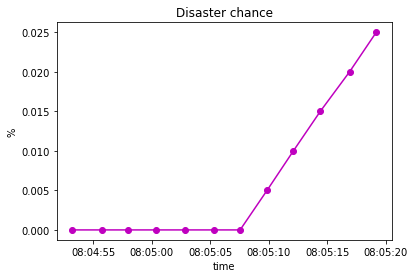

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

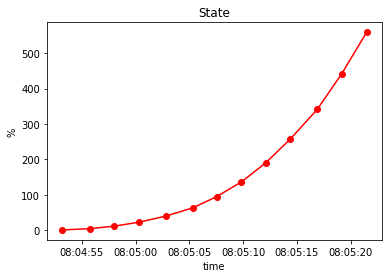

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

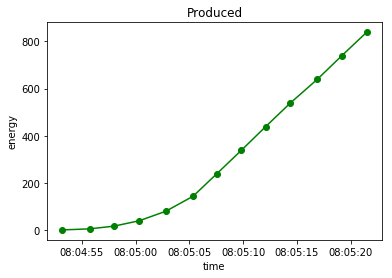

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

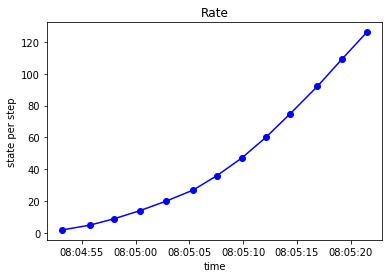

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [0]:
r = Reactor()
r.run()